### Task 1: State rigorously and prove the “Fourier Slice Theorem”. Give its interpretation and explain its connection with MRI


one dimensional function $$k(x) = \int\limits_{-\infty}^{\infty} f(x,y) \ dy$$
with the Fourier Transform $$F(k_x, k_y) = \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} f(x,y)*e^{-i2\pi(k_xx+k_yy)} \ dydx$$
When we select a slice $s(k_x)$ through $F(k_x,k_y)$, $$s(k_x) = F(k_x,0)$$
the Fourier transform becomes
$$F(k_x, 0) = \int\limits_{-\infty}^{\infty} \left[ \int\limits_{-\infty}^{\infty} f(x,y)dy\right]*e^{-i2\pi k_xx} \  dx$$
which is nothing but the Fourier transform of $k(x)$
$$F(k_x, k_y) = \int\limits_{-\infty}^{\infty} k(x)*e^{-i2\pi k_xx} \ dx$$
This result states, that we can interpolate many sliced fourier transformations to get the full fourier transformation and can be extended to higher dimensions. \
With regard to MRI Images, we can aquire many 2D slices in order to get the 3D fourier transformation and reconstruct the 3D scene. In addition, many 2D reconstructions help the physician to gain more information about the insight of the scanned part.

### Task 2: Write, in Julia, a software that simulates the reconstruction from “Standard sequential Cartesian filling of k-space with left-to-right frequency-encoding”, “Centric ordering of k-space acquisition” and the “Outward radial ordering of k-space” from http://mriquestions.com/k-space-trajectories.html



In [1]:
using PyCall
using LinearAlgebra
using Images
using FFTW
using Printf
animation = pyimport("matplotlib.animation")
celluloid = pyimport("celluloid")
using Latexify
using LaTeXStrings
using HDF5
using PyPlot
using Random

In [33]:
PyPlot.matplotlib.use("TkAgg")

In [34]:
N = 500;
Img = shepp_logan(N, highContrast = true);

In [35]:
#Fourier tranbsform of shepp logan
fourier_shepp = FFTW.fft(Img) ;
fshift = FFTW.fftshift(fourier_shepp)
magnitude =  log.(abs.(fshift))
@show size(magnitude)
@show size(Img)

size(magnitude) = (500, 500)
size(Img) = (500, 500)


(500, 500)

#### "Standard sequential Cartesian filling of k-space with left-to-right frequency-encoding"

In [36]:
recon = Array{Complex{Float64}, 2}(undef, N,N);
mask = zeros(N,N);
j=1;
fig, (ax1, ax2) = subplots(1,2)
camera = celluloid.Camera(fig)
im1 = ax1.imshow(Img, cmap="gray")
im2 = ax2.imshow(magnitude, cmap="gray")
for i=1:5:N 
    mask[:, 1:i].=1 ;
    recon = fshift.*mask;
    recon_coeffs = magnitude.*mask;
    finv = FFTW.ifft(recon);
    abf = abs.(finv) ;
    im1.set_array(abf);
    im2.set_array(recon_coeffs);
    pause(0.005)
    camera.snap()
    j = j+1;
    #@show size(log_recon)
    #@show recon_coeffs[1,1]
end
#animation = camera.animate()
#animation.save("animation.gif", writer="PillowWriter", fps=80)

In [37]:

x=1:N;
y = 1:N;
columns = zeros(N,N);
rows = zeros(N,N);
for i=0:N-2
    rows[i+1,:] = x;
    columns[:,i+1] = y;
end
centerX = N/2;
centerY = N/2;

#### “Outward radial ordering of k-space” 

In [38]:
mask = zeros(N,N);
j=1;
fig, (ax1, ax2) = subplots(1,2)
camera = celluloid.Camera(fig)
im1 = ax1.imshow(Img, cmap="gray")
im2 = ax2.imshow(magnitude, cmap="gray")
for i=1:2:N
    circlePixels = (rows.-centerX).^2 + (columns .- centerY).^2 .<= i^2
    mask = circlePixels
    recon = fshift.*mask;
    recon_coeffs = magnitude.*mask;
    finv = FFTW.ifft(recon);
    abf = abs.(finv) ;
    im1.set_array(abf);
    im2.set_array(recon_coeffs);
    pause(0.01)
    camera.snap()
    j = j+1;
    #@show size(log_recon)
    #@show recon_coeffs[1,1]
end
#animation = camera.animate()

#### “Centric ordering of k-space acquisition”

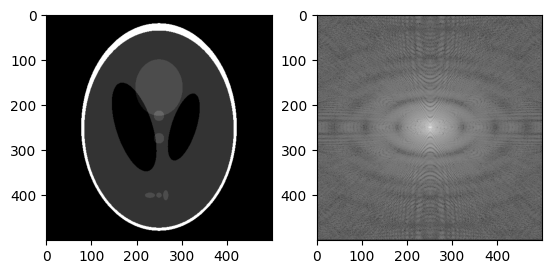

In [120]:
mask = zeros(N,N);
j=1;
fig, (ax1, ax2) = subplots(1,2)
camera = celluloid.Camera(fig)
im1 = ax1.imshow(Img, cmap="gray")
im2 = ax2.imshow(magnitude, cmap="gray")
for i=1:2:Int16(fld(N,2)) 
    mask[Int16(centerX)-i:Int16(centerX)+i, :].=1 ;
    recon = fshift.*mask;
    recon_coeffs = magnitude.*mask;
    finv = FFTW.ifft(recon);
    abf = abs.(finv) ;
    im1.set_array(abf);
    im2.set_array(recon_coeffs);
    pause(0.01)
    camera.snap()
    j = j+1;
    #@show size(log_recon)
    #@show recon_coeffs[1,1]
end
#animation = camera.animate()

### Task3: What is the difference between synthesis sparse models and analysis sparse models? Why the analysis sparse models are harder to analyze? 
 

Analysis sparse models, analyze the models behaviour and optimize a cost function, which mostly uses the $l2$ or $l1$ norm for convexity. One possible analysis operator would be the gradient, which is commonly used in image analysis. The issue about this approach is the lack of information about the signal. \
The synthesis approach assumes, that the signal has a sparse representation and the signal can be reconstructed by a few columns of the fat and short dictionary matrix D. The recovery cost function in this approach seeks for the sparsest reconstruction of X using the $l1$ norm.


### Task4: What is the different between cartesian Fourier transform and non-cartesian Fourier transform? How to use NFFT in Julia?


The cartesian Fourier transform is based on a signal that is sampled or appears in equidistant time or frequency space. If that is not the case, the signal can be shifted and transformed to the cartesian basis, which results in a biased transformation and is one of the major drawbacks. In order to tackle this problem, the non-cartesian fourier transformation can transform any time or frequency space by polynomial approximation. An example code in julia is shown below.

In [57]:
using NFFT

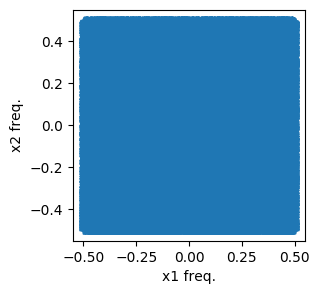

In [61]:
x = rand(2,500000).-0.5   # Alternatively use this random sampling
figure(figsize = (3,3))
plot(x[1,:], x[2,:],"+");
#PyPlot.xlim([-0.5,0.5]);
#PyPlot.ylim([-0.5,0.5]);
xlabel("x1 freq.");
ylabel("x2 freq.");

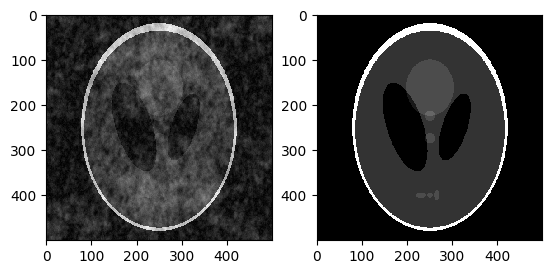

In [62]:
N=500

p = NFFTPlan(x, (N,N))
g = nfft(p, complex(Img))
f = nfft_adjoint(p, g)

fig, (ax1, ax2) = subplots(1,2)
ax1.imshow(abs.(f), cmap="gray")
ax2.imshow(Img, cmap="gray");


### Task5: What is a spin echo imaging? What is a gradient echo imaging? What are the advantages and disadvantages of both?

A spin echo is produced by two radio frequency(RF) pulses. The first decays with time T2 but the information is not lost because many of the T2 processes are symmetrically reversible. Due to the second pulse, the signal can refocuse, which results in a spin echo. The time between the middle of the first RF pulse and the spin echo peak is called the echo time. \
The spin echo images are more robust against inhomogenities in the magnetic field. Otherwise, a new excitation can be done after the echo time. Hence, the long aquisition time is a major disadvantage. \
In contrast, gradient echos are generated by only one signal, which has a negative dephasing gradient and after shifting the gradient by 10- 80 degree, a positive rephasing gradient - the echo appears and can be measured. \
This result implies the first advantage, that the shift can be done much faster and more often than with the echo spin and therefore, the aquisition time is faster. 
On the other hand, the echo gradient images show artifacts due to inhomogenities in the constant magnetic field.